## Background

__Twitter__ has become a wildly sprawling jungle of information&mdash;140 characters at a time. Somewhere between 350 million and 500 million tweets are estimated to be sent out _per day_. With such an explosion of data, on Twitter and elsewhere, it becomes more important than ever to tame it in some way, to concisely capture the essence of the data.

## News Mood

A python script to perform a sentiment analysis of the Twitter activity of various news oulets, and to present your findings visually.

Your final output should provide a visualized summary of the sentiments expressed in Tweets sent out by the following news organizations: __BBC, CBS, CNN, Fox, New York times and W Post__.



The first plot will be and/or feature the following:

* Be a scatter plot of sentiments of the last __100__ tweets sent out by each news organization, ranging from -1.0 to 1.0, where a score of 0 expresses a neutral sentiment, -1 the most negative sentiment possible, and +1 the most positive sentiment possible.
* Each plot point will reflect the _compound_ sentiment of a tweet.
* Sort each plot point by its relative timestamp.

The second plot will be a bar plot visualizing the _overall_ sentiments of the last 100 tweets from each organization. For this plot, you will again aggregate the compound sentiments analyzed by VADER.

The tools of the trade you will need for your task as a data analyst include the following: tweepy, pandas, matplotlib, seaborn, textblob, and VADER.

Included analysis:

* Pull last 100 tweets from each outlet.
* Sentiment analysis with the compound, positive, neutral, and negative scoring for each tweet. 
* A DataFrame the tweet's source acount, its text, its date, and its compound, positive, neutral, and negative sentiment scores.
* DataFrame into a CSV file.
* PNG images for each plot.

In [209]:
import tweepy
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from config import consumer_key, consumer_secret, access_token, access_token_secret

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [210]:
# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [211]:
#list of the news outlet - on Tweeter 

news_outlets=['BBC', 'CBS', 'CNN', 'FoxNews' , 'nytimes', 'washingtonpost']
#news_outlets=['CNN',  'FoxNews', 'nytimes']
#news_outlets=("@BBCNorthAmerica", "@CBS", "@CNN","@FoxNews", "@nytimes", "@washingtonpost")

In [212]:
#Initiating and empty table to hold data from twitter   
cols=['Tweets', 'Followers', 'Following', 'Favorites Count']
popular_news= pd.DataFrame(index=news_outlets ,columns=cols).reset_index()
popular_news=popular_news.rename(columns = {'index':'Screen Name'})

In [213]:
# Iterate through DataFrame
for index, row in popular_news.iterrows():
    try:
        # Grab the username
        target_user = row["Screen Name"]
        # print(target_user)

        # Use the username with the Twitter API get_user
        user_account = api.get_user(target_user)
        user_real_name = user_account["name"]

        # Get the specific column data
        user_tweets = user_account["statuses_count"]
        user_followers = user_account["followers_count"]
        user_following = user_account["friends_count"]
        user_favorites = user_account["favourites_count"]

        # Replace the row information for each
        popular_news.set_value(index, "Real Name", user_real_name)
        popular_news.set_value(index, "Tweets", user_tweets)
        popular_news.set_value(index, "Followers", user_followers)
        popular_news.set_value(index, "Following", user_following)
        popular_news.set_value(index, "Favorites Count", user_favorites)

    except tweepy.TweepError as e:
        print(e)
        
#set index with Real Name for nice ploting 
popular_news.set_index('Real Name', inplace=True)
popular_news

Failed to send request: ('Connection aborted.', OSError("(10054, 'WSAECONNRESET')",))


,Screen Name,Tweets,Followers,Following,Favorites Count
Real Name,,,,,
BBC,BBC,20043,1136877,159,3595
CBS,CBS,16002,947316,490,1754
CNN,CNN,159843,38625814,1115,1476
Fox News,FoxNews,345524,16542196,407,0
The New York Times,nytimes,301022,40356209,884,15876
NaN,washingtonpost,NaN,NaN,NaN,NaN


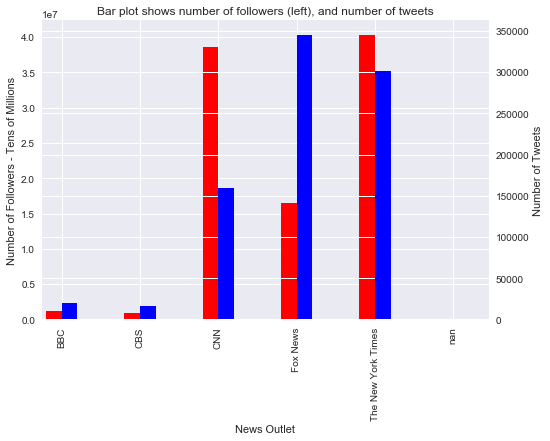

In [214]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()

width = 0.2

popular_news['Followers'].plot(kind='bar', color='red', ax=ax, width=width, position=1)
popular_news['Tweets'].plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Number of Followers - Tens of Millions')
ax2.set_ylabel('Number of Tweets')
ax.set_xlabel('News Outlet')

plt.title('Bar plot shows number of followers (left), and number of tweets')

plt.show()

In [215]:
# making dir for porper label real name vs. screen name 

real_name=popular_news.reset_index()['Real Name'].tolist()
scre_name=popular_news.reset_index()['Screen Name'].tolist()

real_name_dir={}

for i in range(len(real_name)):
    real_name_dir[scre_name[i]]=real_name[i]

real_name_dir



{'BBC': 'BBC',
 'CBS': 'CBS',
 'CNN': 'CNN',
 'FoxNews': 'Fox News',
 'nytimes': 'The New York Times',
 'washingtonpost': nan}

In [216]:
# Target User
#news_outlets =('BBC', 'CBS', 'CNN', 'FoxNews', 'nytimes', 'washingtonpost' ) 

#Create Dir to hold extracted data 
sentement_scores={}

for news_outlet in news_outlets:

    # Place holders 
    date_time=[]
    tweet_texts =[]
    compounds=   [] 
    neg_score=   []
    pos_score=   []
    neu_score=   []
    tweet_num=   []

    # Create a loop to iteratively run API requests
    num=1
    for tweet_page in range(1,6):

        # Get all tweets from home feed (for each page specified)
        public_tweets = api.user_timeline(news_outlet, page=tweet_page)

        # Loop through all tweets
        for tweet in public_tweets:


            # tweet Number 
            tweet_num.append(num)
            num+=1
            # Print Tweet
            #print(tweet["text"])
            
            #extract date 
            date_time.append(tweet['created_at'])

            # Store Tweet in Array
            tweet_texts.append(tweet["text"])
            
            # store veda in array 
            compound=analyzer.polarity_scores(tweet["text"])['compound']
            
            #print(compound)
            compounds.append(compound)
            
            neg=analyzer.polarity_scores(tweet["text"])['neg']
            neg_score.append(neg)
            
            # print most neg news
            if neg > .55:
                print(tweet["text"])
                print(news_outlet)
                print(f'Negative News Score (0 to 1) : {neg}')
                print('__')
                

            
            pos=analyzer.polarity_scores(tweet["text"])['pos']
            pos_score.append(pos)
            
            # print most pos news 
            if pos > .55:
                print(tweet["text"])
                print(news_outlet)
                print(f'Positive News Score (0 to 1): {pos}')
                print('__')
            
            neu=analyzer.polarity_scores(tweet["text"])['neu']
            neu_score.append(neu)
    
    #Dirctory with all data for the current news outlet 
    sentement_scores[news_outlet]=(tweet_num, date_time, compounds, neg_score, pos_score, neu_score, tweet_texts)

Porcelain perfection. 😘  #VSFashionShow https://t.co/XQe14ycc1j
CBS
Positive News Score (0 to 1): 0.552
__
Two more arrested in brutal MS-13 murder where victim was maimed, decapitated https://t.co/SOGiMKKkVd
FoxNews
Negative News Score (0 to 1) : 0.618
__
The 5 best romance novels of 2017 https://t.co/iSh0nN3KHJ https://t.co/OEgtSoxEwt
washingtonpost
Positive News Score (0 to 1): 0.565
__


In [217]:
# a function to to make data frame for each news outlet data 

def pol_df(news_outlet):
    scores={'Tweet_number': sentement_scores[news_outlet][0],
            'Date':sentement_scores[news_outlet][1],
            'Compound':sentement_scores[news_outlet][2],
            'Negative':sentement_scores[news_outlet][3],
            'Positive':sentement_scores[news_outlet][4],
            'Neutral':sentement_scores[news_outlet][5],
            'Tweet':sentement_scores[news_outlet][6],
            'News_outlet': news_outlet
           }
    return(pd.DataFrame(scores)) 

In [218]:
# create empty data frame 
cols=['News_outlet', 'Tweet_number', 'Date', 'Positive',  'Negative', 'Neutral', 'Compound', 'Tweet']
news_outlets_sentements = pd.DataFrame(columns=cols)

In [219]:
for news_outlet in news_outlets:
    news_outlet_data=pol_df(news_outlet)
    news_outlets_sentements = news_outlets_sentements.append(news_outlet_data)

In [220]:
news_outlets_sentements.reset_index(drop=True, inplace=True)

In [221]:
raw_date=news_outlets_sentements['Date'].tolist()
dates=[datetime.strptime(raw_stamp, "%a %b %d %H:%M:%S %z %Y") for raw_stamp in raw_date]
dates_array=np.asarray(dates)
#pd.Series(test3)
news_outlets_sentements.insert(0, 'Date_time', dates_array)


#drop old raw date 
news_outlets_sentements.drop('Date', axis=1, inplace=True)

In [222]:
#QC Step 
news_outlets_sentements.head() # check data - should have all the outles . head  

,Date_time,Compound,Negative,Neutral,News_outlet,Positive,Tweet,Tweet_number
0,2017-12-02 15:05:11+00:00,0.4404,0.000,0.861,BBC,0.139,Have you seen it yet? 😍 Here's everything you ...,1
1,2017-12-02 15:00:05+00:00,-0.5423,0.280,0.720,BBC,0.000,Has the sexual harassment controversy hit chil...,2
2,2017-12-02 14:53:58+00:00,0.0258,0.152,0.657,BBC,0.190,RT @bbcstories: Errol’s a mechanic and prostat...,3
3,2017-12-02 14:52:52+00:00,0.6952,0.000,0.758,BBC,0.242,"RT @BBCOne: ⚡️ ""I'm not crying, YOU'RE crying!...",4
4,2017-12-02 14:52:22+00:00,0.0000,0.000,1.000,BBC,0.000,RT @BBCSportWales: Fancy watching #WALvRSA wit...,5


In [223]:
#QC Step 
news_outlets_sentements.tail() # check data - should have all the outles . tail for last news outlet  

,Date_time,Compound,Negative,Neutral,News_outlet,Positive,Tweet,Tweet_number
595,2017-12-01 18:44:07+00:00,0.7506,0.000,0.584,washingtonpost,0.416,North Koreans celebrate missile launch with fi...,96
596,2017-12-01 18:40:15+00:00,-0.4215,0.177,0.823,washingtonpost,0.000,Fact Checker: Here's the complete timeline lea...,97
597,2017-12-01 18:29:36+00:00,-0.8126,0.375,0.625,washingtonpost,0.000,Perspective: What churches must do right now t...,98
598,2017-12-01 18:22:08+00:00,-0.5116,0.249,0.751,washingtonpost,0.000,Analysis: If Trump pressured senators to end t...,99
599,2017-12-01 18:13:03+00:00,0.0000,0.000,1.000,washingtonpost,0.000,Perspective: We live in an era where everythin...,100


In [224]:
# QC step 
news_outlets_sentements.shape # should have number of rows - for this case study 600 

(600, 8)

In [225]:
# QC step 
set(news_outlets_sentements['News_outlet'].tolist()) # check if all outlets are extracted and yes 6 of them 

{'BBC', 'CBS', 'CNN', 'FoxNews', 'nytimes', 'washingtonpost'}

In [226]:
# map the real name instd of screen name for proper labeling 
news_outlets_sentements['News_outlet'] = news_outlets_sentements['News_outlet'].map(real_name_dir)

In [227]:
news_outlets_sentements

,Date_time,Compound,Negative,Neutral,News_outlet,Positive,Tweet,Tweet_number
0,2017-12-02 15:05:11+00:00,0.4404,0.000,0.861,BBC,0.139,Have you seen it yet? 😍 Here's everything you ...,1
1,2017-12-02 15:00:05+00:00,-0.5423,0.280,0.720,BBC,0.000,Has the sexual harassment controversy hit chil...,2
2,2017-12-02 14:53:58+00:00,0.0258,0.152,0.657,BBC,0.190,RT @bbcstories: Errol’s a mechanic and prostat...,3
3,2017-12-02 14:52:52+00:00,0.6952,0.000,0.758,BBC,0.242,"RT @BBCOne: ⚡️ ""I'm not crying, YOU'RE crying!...",4
4,2017-12-02 14:52:22+00:00,0.0000,0.000,1.000,BBC,0.000,RT @BBCSportWales: Fancy watching #WALvRSA wit...,5
5,2017-12-02 14:51:55+00:00,0.7884,0.000,0.782,BBC,0.218,RT @bbcweather: The pictures we post usually r...,6
6,2017-12-02 14:30:04+00:00,0.7650,0.000,0.708,BBC,0.292,🎄🎁 Rip Off Britain give some tips on how to ge...,7
7,2017-12-02 13:47:35+00:00,0.0000,0.000,1.000,BBC,0.000,RT @bbcthree: The moving story of the woman wi...,8
8,2017-12-02 13:33:03+00:00,-0.3818,0.157,0.843,BBC,0.000,"Bands, denim and leather. 🤘 Photographer Dan G...",9
9,2017-12-02 13:03:03+00:00,0.0000,0.000,1.000,BBC,0.000,This man is heading into the sky in a homemade...,10


In [230]:
compund=news_outlets_sentements.pivot(index='Tweet_number', columns='News_outlet', values='Compound')

##  Sentiment Polarity Analysis of each news_outlet

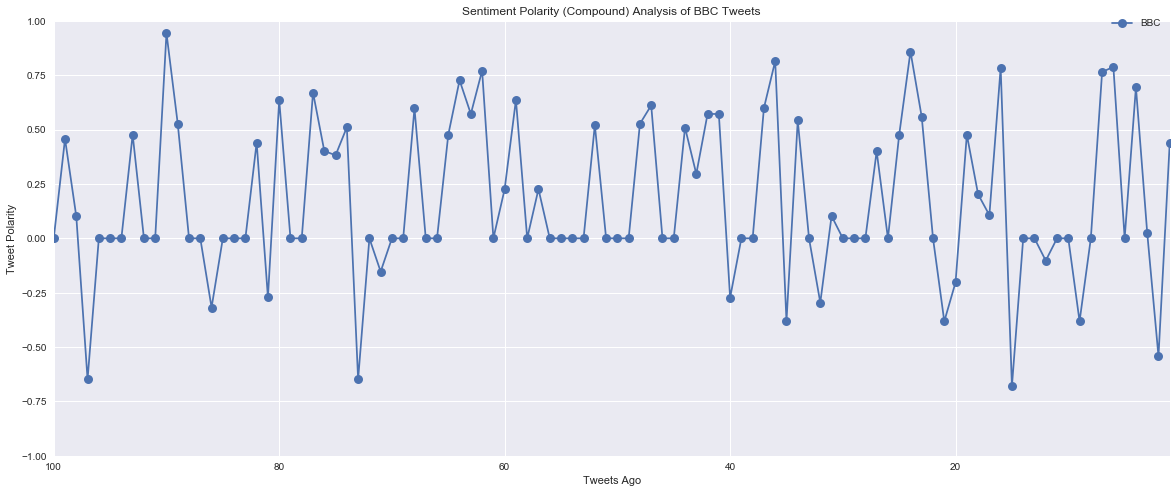

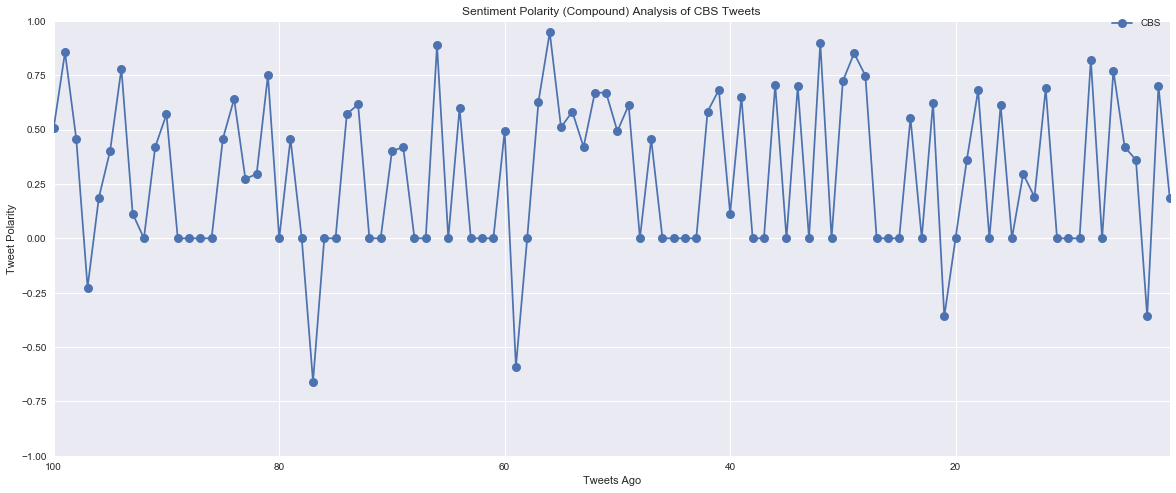

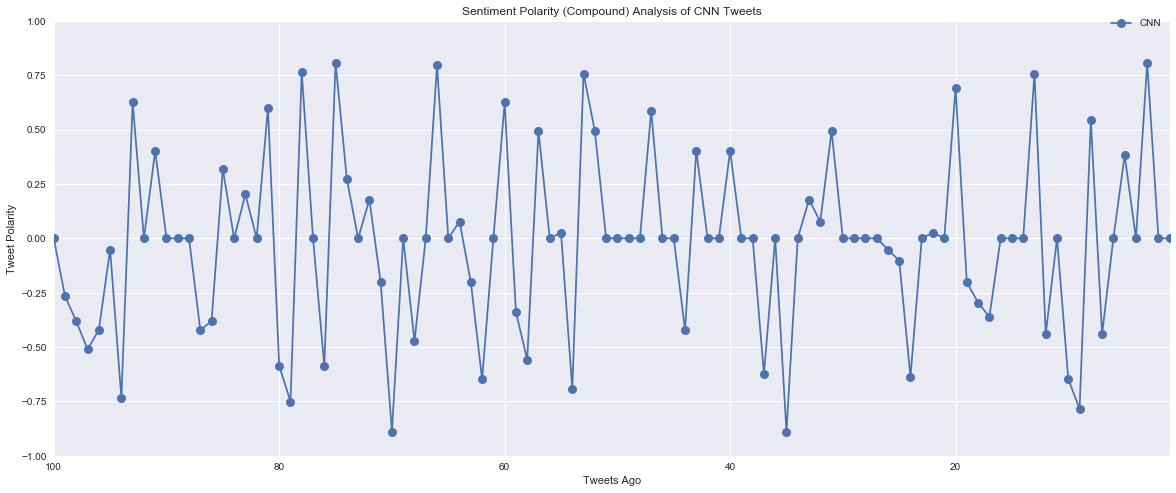

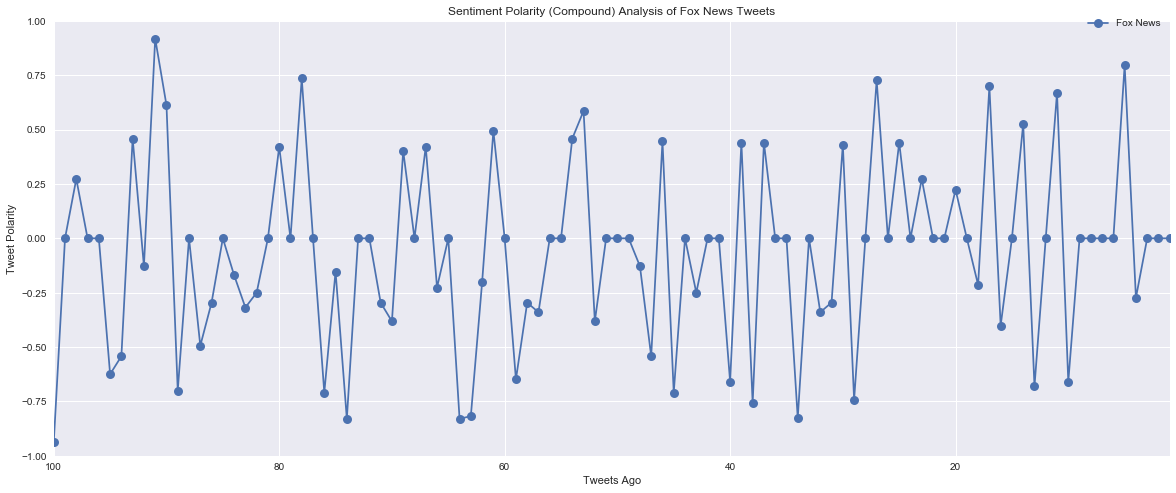

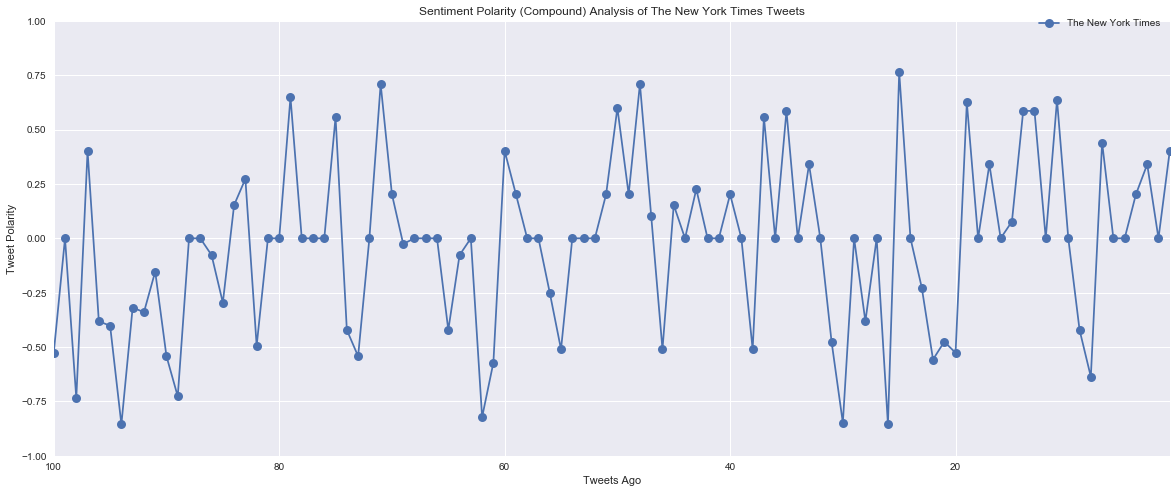

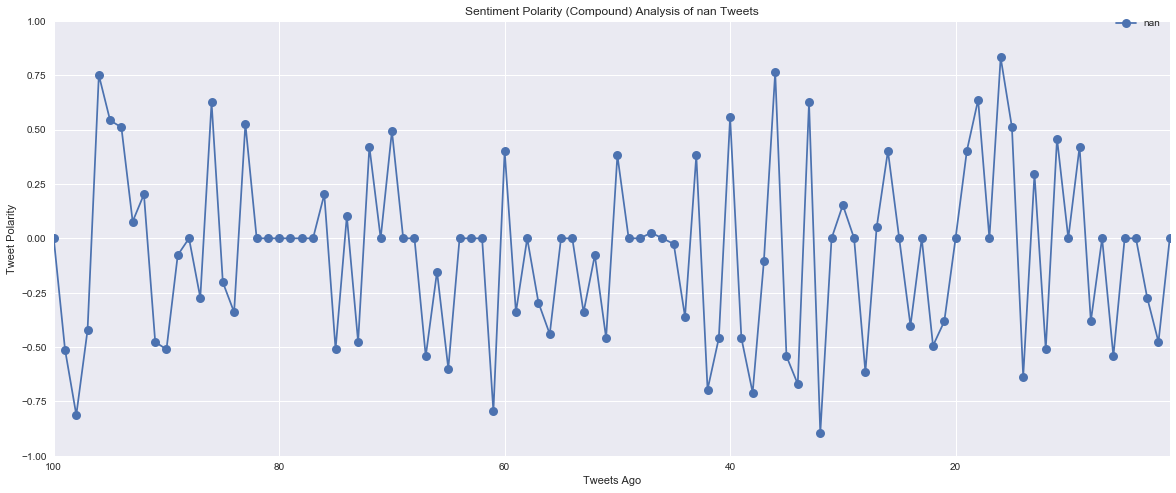

In [233]:
news_outlets=real_name
for news_outlet in news_outlets:
    compund[news_outlet].sort_index(ascending=False).plot(marker = 'o', grid=True,style='-', ms=9, figsize=(20,8))
    plt.legend(bbox_to_anchor=(1, 1.025))
    plt.xlabel('Tweets Ago')
    plt.ylabel('Tweet Polarity')
    plt.title(f'Sentiment Polarity (Compound) Analysis of {news_outlet} Tweets')
    plt.ylim(-1,1)

    plt.show();

##  Sentiment Polarity Analysis of all news_outlet

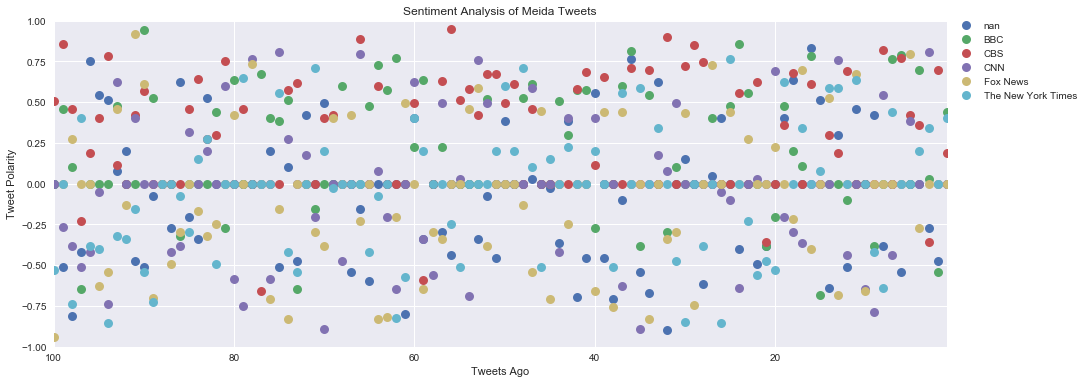

In [234]:
compund.sort_index(ascending=False).plot(marker = 'o', grid=True,style=' ', ms=9, figsize=(16,6))
plt.legend(bbox_to_anchor=(1, 1.025))
plt.xlabel('Tweets Ago')
plt.ylabel('Tweet Polarity')
plt.title('Sentiment Analysis of Meida Tweets')
plt.ylim(-1,1)

plt.show();

##  Sentiment Polarity Analysis of all news_outlet Bar plot ( mean) and Swarmplot 

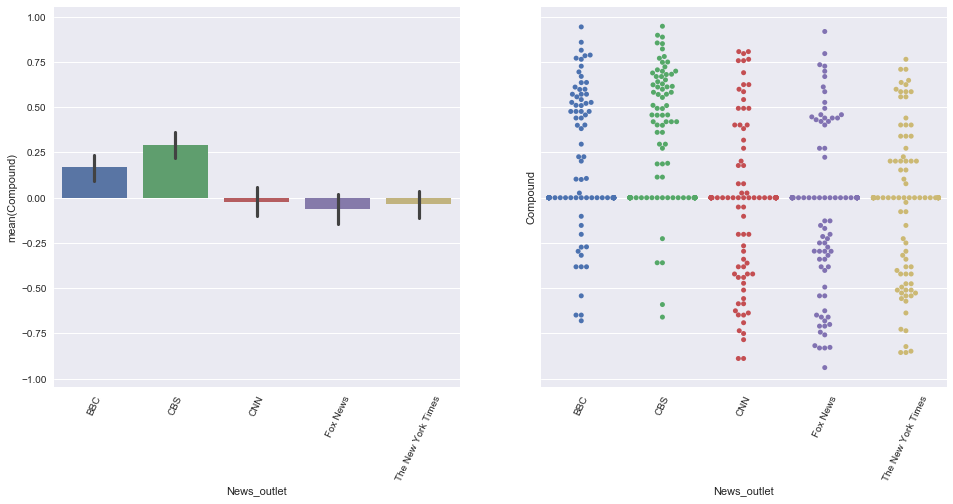

In [237]:
fig, axs = plt.subplots(ncols=2, figsize=(16,7), sharey=True)

a=sns.barplot(x='News_outlet', y='Compound', data=news_outlets_sentements, ax=axs[0])
for item in a.get_xticklabels():
    item.set_rotation(65)
b=sns.swarmplot(x='News_outlet', y='Compound', data=news_outlets_sentements, ax=axs[1])
for item in b.get_xticklabels():
    item.set_rotation(65)
plt.show()

## Kernel density estimaton - distribution of news outlets - compound score
Helps understand the data disputation
 

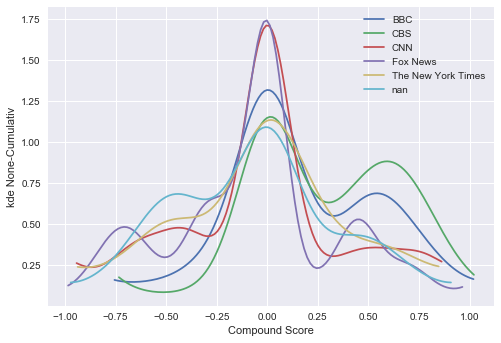

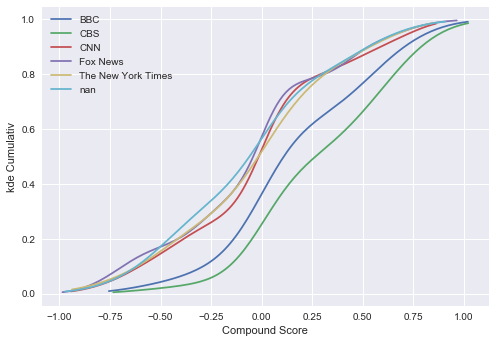

In [238]:
# create a histogram. By default it adds the kde (kernel density estimate)
for i in news_outlets:
    sns.kdeplot(compund[i], shade=False, cut=0.5, cumulative=False)
plt.xlabel('Compound Score')
plt.ylabel('kde None-Cumulativ')
plt.show()


# create a histogram. By default it adds the kde (kernel density estimate)
for i in news_outlets:
    sns.kdeplot(compund[i], shade=False, cut=0.5, cumulative=True)
plt.xlabel('Compound Score')
plt.ylabel('kde Cumulativ')
plt.show()



## Bar plot ( mean) Positive, Neutral and Negative sentements


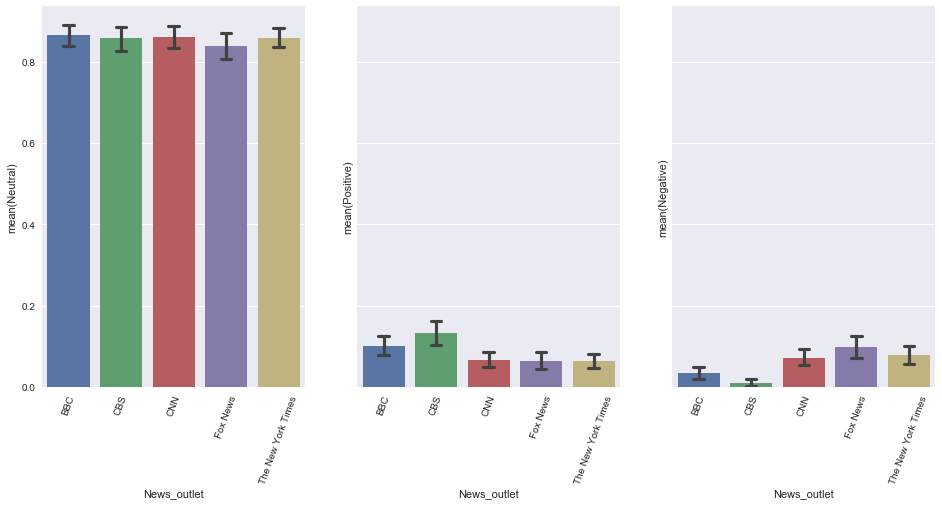

In [239]:
fig, axs = plt.subplots(ncols=3, figsize=(16,7), sharey=True)

a=sns.barplot(x='News_outlet', y='Neutral', data=news_outlets_sentements, ax=axs[0], capsize=.2)
for item in a.get_xticklabels():
    item.set_rotation(70)

b=sns.barplot(x='News_outlet', y='Positive', data=news_outlets_sentements, ax=axs[1] , capsize=.2)
for item in b.get_xticklabels():
    item.set_rotation(70)
    
c=sns.barplot(x='News_outlet', y='Negative', data=news_outlets_sentements, ax=axs[2], capsize=.2)
for item in c.get_xticklabels():
    item.set_rotation(70)

plt.show()


## Sentiment score vs. Time Series plots  

In [240]:
def plot_time_scores(score):
    fig = plt.figure(figsize=(16,7))
    ax = fig.add_subplot(1, 1, 1)

    markers=['bo', 'go', 'ro', 'co', 'mo', 'ko']
    
    counter=0

    for news_outlet in news_outlets:
        data = news_outlets_sentements[news_outlets_sentements['News_outlet']==news_outlet]
        ax.plot(data.Date_time, data[score], markers[counter], label=news_outlet)
        counter+=1

    ax.legend()
    plt.title(f'Time vs Sentiment score ({score})')
    plt.xlabel('Time')
    plt.ylabel(f'{score} score')
    #plt.annotate('test', xy=(data['Date_time'].sort_values().iloc[0], .5))

    plt.show()

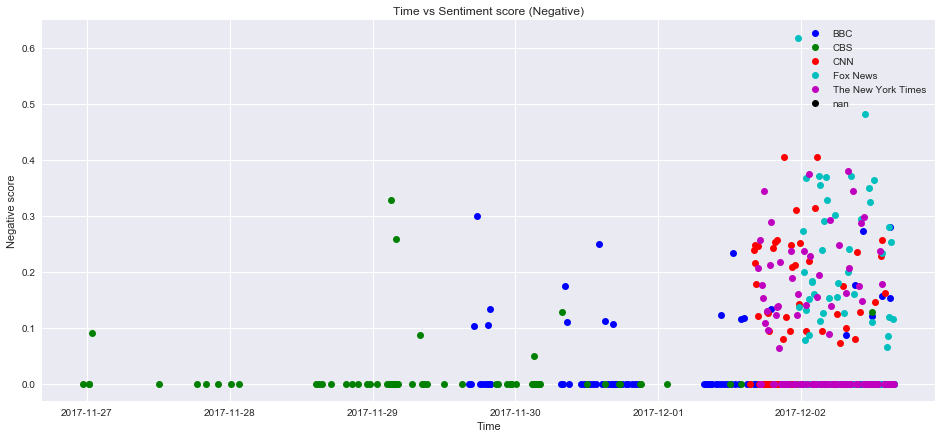

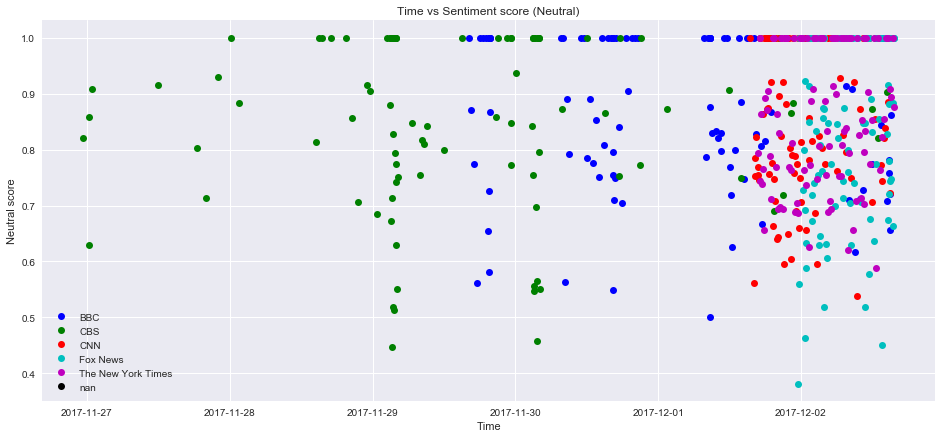

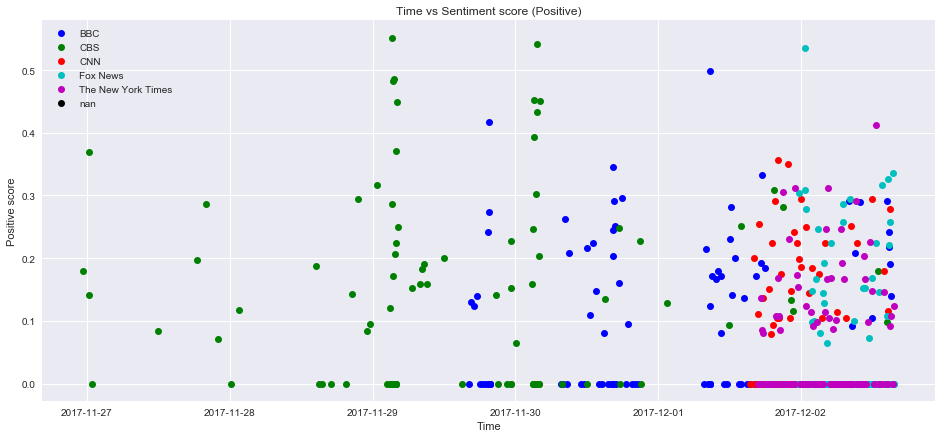

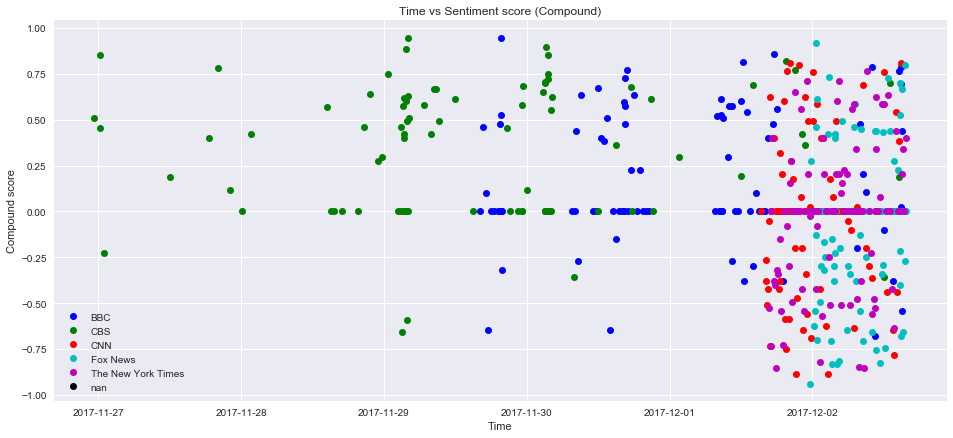

In [241]:
scores=['Negative', 'Neutral', 'Positive', 'Compound']
for score in scores:
    plot_time_scores(score)